# Optuna
### Workshop 5
*July 1th - IACS-MACI Internship*

<img src="images/banner.png" width="1000"/>

Models depend on **[hyper]**parameters that control the learning process and model capabilities. 
The word **parameter** is usually used to refer statistical random variables. 

Looking for hyperparameters is very hard! 

In order to test the model architecture, we often set them arbitrary or from the experience. But the best model will be the one that maximimize the performance according to **the best configuration of hyperparameters**.

Optuna is an open source framework for **hyperparameter searching**. There are a lot of tools to find hyperparameters but [Optuna is the good option considering the trade-off between the runtime and performance score](https://arxiv.org/pdf/2201.06433.pdf)

Optuna [provides different **sampling algorithms**](https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/003_efficient_optimization_algorithms.html#sampling-algorithms) to **look for the best hyperaparameter configuration**. 

In [1]:
import seaborn as sns
import pandas as pd
import optuna

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

/home/cridonoso/miniconda3/envs/tf2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


First we define a function to load the data

In [2]:
def get_data():
    data = pd.read_csv('./data/tetouan_power_consumption.csv')
    X = data['Humidity']
    y = data['Zone 1 Power Consumption']
    
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X.values[:, None])
    y = scaler.fit_transform(y.values[:, None])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=15)    
    return  X_train, X_test, y_train, y_test

### 1. Objective function

The first step consist in defininf an objective function to be maximized.

Inside the function we have to **suggest values** for the hyperparameters using a `trial` object.

A `trial` object has the following methods:

| Method| Description|
| :-- | --- |
| suggest_categorical(name, choices) | Suggest a value for the categorical parameter.|
| suggest_discrete_uniform(name, low, high, q)| Suggest a value for the discrete parameter.|
| suggest_float(name, low, high, \*[, step, log])| Suggest a value for the floating point parameter.|
| suggest_int(name, low, high[, step, log])| Suggest a value for the integer parameter.|
| suggest_loguniform(name, low, high)| Suggest a value for the continuous parameter. |
| suggest_uniform(name, low, high) | Suggest a value for the continuous parameter. |

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_squared_error

In [37]:
def objective(trial):
    
    X_train, X_test, y_train, y_test = get_data()
    
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    n_neighbors = trial.suggest_int('n_neighbors', 1, 1e4, log=True)
    
    reg_model = KNeighborsRegressor(n_neighbors=n_neighbors,
                                    weights=weights)
    
    reg_model.fit(X_train, y_train)
    y_pred = reg_model.predict(X_test)
    
    mse_err = mean_squared_error(y_test, y_pred)
    return mse_err

### 2. Create a study object and optimize the objective function.

The function `create_study` prepare all the necessary to run the experiments. 

In particular we can select the [`sampler`](https://optuna.readthedocs.io/en/stable/reference/samplers.html#optuna-samplers), remote `storage`, `direction` of the optimization, among others.

In [38]:
from optuna.samplers import RandomSampler

study = optuna.create_study(sampler=RandomSampler(), direction='minimize')
study.optimize(objective, n_trials=20)

[I 2022-06-27 16:15:12,853] A new study created in memory with name: no-name-1f669509-4a40-460e-aea9-a279add54560
[I 2022-06-27 16:15:12,993] Trial 0 finished with value: 0.03185612608681153 and parameters: {'weights': 'uniform', 'n_neighbors': 63}. Best is trial 0 with value: 0.03185612608681153.
[I 2022-06-27 16:15:13,069] Trial 1 finished with value: 0.0454332434772837 and parameters: {'weights': 'distance', 'n_neighbors': 2}. Best is trial 0 with value: 0.03185612608681153.
[I 2022-06-27 16:15:17,076] Trial 2 finished with value: 0.03421370712508737 and parameters: {'weights': 'distance', 'n_neighbors': 2266}. Best is trial 0 with value: 0.03185612608681153.
[I 2022-06-27 16:15:17,157] Trial 3 finished with value: 0.03865695467324151 and parameters: {'weights': 'distance', 'n_neighbors': 5}. Best is trial 0 with value: 0.03185612608681153.
[I 2022-06-27 16:15:17,268] Trial 4 finished with value: 0.0343822375085098 and parameters: {'weights': 'distance', 'n_neighbors': 40}. Best is 

If you want to save the study locally then [you have to use `joblib`](https://optuna.readthedocs.io/en/stable/faq.html#how-can-i-save-and-resume-studies)

In [39]:
print("Best trial until now:")
print(" Value: ", study.best_trial.value)
print(" Params: ")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

Best trial until now:
 Value:  0.03142655338311976
 Params: 
    weights: uniform
    n_neighbors: 691


Then we can use the hyperparameters to create the final (best-found) model

In [40]:
X_train, X_test, y_train, y_test = get_data()

best_model = KNeighborsRegressor(n_neighbors = study.best_trial.params['n_neighbors'],
                                 weights=study.best_trial.params['weights'])

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

mse_err = mean_squared_error(y_test, y_pred)
mse_err

0.03142655338311976

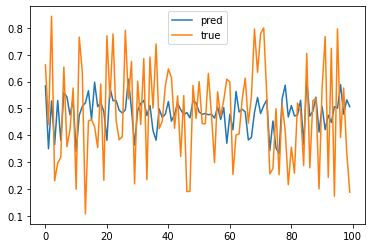

In [41]:
import matplotlib.pyplot as plt 


fig, ax = plt.subplots()
ax.plot(y_pred[:100], label='pred')
ax.plot(y_test[:100], label='true')
ax.legend()
plt.show()


## Visualization

For summary visualization we can use [the `visualization` module](https://optuna.readthedocs.io/en/stable/reference/visualization/index.html#optuna-visualization) of Optuna.  It bring us matplotlib/plotly plots to display the results of the study.

Notice we need to install `plotly` toghether with `matplotlib`
```
pip install plotly==5.9.0
```

In [43]:
fig = optuna.visualization.plot_parallel_coordinate(study, 
                                                    params=["n_neighbors", "weights"])
fig.show()

In [44]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()